# But du projet

Les données viennent du dataset [ISPRS Potsdam](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-potsdam/). Le but est de classifier les images au niveau du pixel selon 4 classes: Routes, Batiments, Végétation et Autre. Nous considérons avoir 80% du jeu de données pour l'entraînement et 20% pour l'évaluation. 

Les images étant trop grosses pour être traitées directement par des réseaux de neurones, il faudra découper les images en tuiles pour pouvoir les traiter correctement. Vous pouvez aussi sous-échantilloner les données et observer l'effet de ce sous-échantillonage sur les performances. 

Une information géométrique est également disponible (hauteur via le DSM), vous pourrez tester son utilité pour améliorer les prédictions.

De nombreuses architectures de réseaux de neurones existent pour la segmentation sémantique; vous pouvez en tester quelques unes différentes en essayant de comprendre les différences entre celles-ci.

Le code fourni permet de charger les données, de les séparer en un jeu d'entrainement et un de validation, de les visualiser et de calculer les métriques à partir de vos futures prédictions. À vous de tester des architectures, différents pré-processing (différents tuilages ou augmentations de données) et d'analyser vos résultats !

Les commentaires #TODO peuvent vous donner des pistes sur ce qu'il faut faire.


# Import and seeds

In [20]:
import colorsys
import itertools
import os
import sys
from glob import glob
from os.path import join

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab import drive
from sklearn.metrics import confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True

# Google collab

In [21]:

drive.mount('/content/gdrive')
TD_DIR = 'gdrive/My Drive/ENSTA/MI203/Projet'
sys.path.append(TD_DIR)
print(os.path.exists(TD_DIR))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
True


# On instancie les variables globales

In [22]:
DATA_FOLDER = "./Potsdam/30cm"  # ou sont les données
BATCH_SIZE = 2
N_CLASSES = 4  
WINDOW_SIZE = 256
OVERLAP = 0
LENGTH_EPOCH = 100
DEVICE = "cuda"

# Dataloader d'entrainement

In [23]:
def get_random_pos(img, window_shape):
    W, H = img.shape[-2:]    
    
    x1 = np.random.randint(0, W - window_shape - 1)
    x2 = x1 + window_shape

    y1 = np.random.randint(0, H - window_shape - 1)
    y2 = y1 + window_shape

    return x1, x2, y1, y2

class Potsdam_train_dataset(torch.utils.data.Dataset):
    def __init__(self, img_files, cache=False,):
        super(Potsdam_train_dataset, self).__init__()
        
        self.cache = cache
        
        # List of files
        self.img_files = img_files
        self.gt_files = [i.replace("imgs", "gts") for i in self.img_files]
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
    
    def __len__(self):
        return LENGTH_EPOCH

    def data_augmentation(self, img, gt):
        #TODO ...
        return img, gt
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = np.random.randint(0, len(self.img_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys() and random_idx in self.label_cache_.keys():
            data = self.data_cache_[random_idx]
            label = self.label_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * cv.imread(self.img_files[random_idx])[..., ::-1].transpose((2, 0, 1)) # OpenCV reads imags in BGR
            label = cv.imread(self.gt_files[random_idx], 0)
            if self.cache:
                self.data_cache_[random_idx] = data
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return torch.from_numpy(data_p), torch.from_numpy(label_p)

# Fonctions pour la visualisation

In [24]:
# Utils to visualize data
def visualize(image, target):
  colors = random_colors(N_CLASSES)
  plt.figure(figsize=(20,20))
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.subplot(1,2,2)
  plt.imshow(apply_mask(image, target, colors))
  plt.show()

def random_colors(n, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n, 1, brightness) for i in range(n)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    np.random.shuffle(colors)
    return colors


def apply_mask(image, mask, colors, alpha=0.5):
    """Apply the given mask to the image. Binary mask.
    """
    target = image.copy()
    for i, color in enumerate(colors):
      for c in range(3):
          target[:, :, c][mask == i] =  image[:, :, c][mask == i] * (1 - alpha) + alpha * color[c]
    return target

# Métriques

En segmentation sémantique, on utilise souvent l'[Intesection sur l'Union](https://en.wikipedia.org/wiki/Jaccard_index) (ou Indice de Jaccard) pour évaluer les performances. Vous pouvez également regarder d'autres métriques pour voir les différences.

In [25]:
# Metrics
def iou_from_matrix(matrix):
    TP = np.diag(matrix)
    FN = np.sum(matrix,1) - TP
    FP = np.sum(matrix,0) - TP
    return TP/(TP+FN+FP)

def get_metrics(target, pred):
  pred = pred.flatten()
  target = target.flatten()
  confusion = confusion_matrix(target, pred)
  # iou = jaccard_score(target, pred, labels=np.arange(N_CLASSES), average=None)  # Much slower
  iou = iou_from_matrix(confusion)
  return confusion, iou


# Split des données train/test

In [26]:
img_files = glob(join(TD_DIR, DATA_FOLDER, "imgs", '*.tif'))
train_imgs, test_imgs = train_test_split(img_files, test_size=0.2, random_state=42)    

# On visualise 

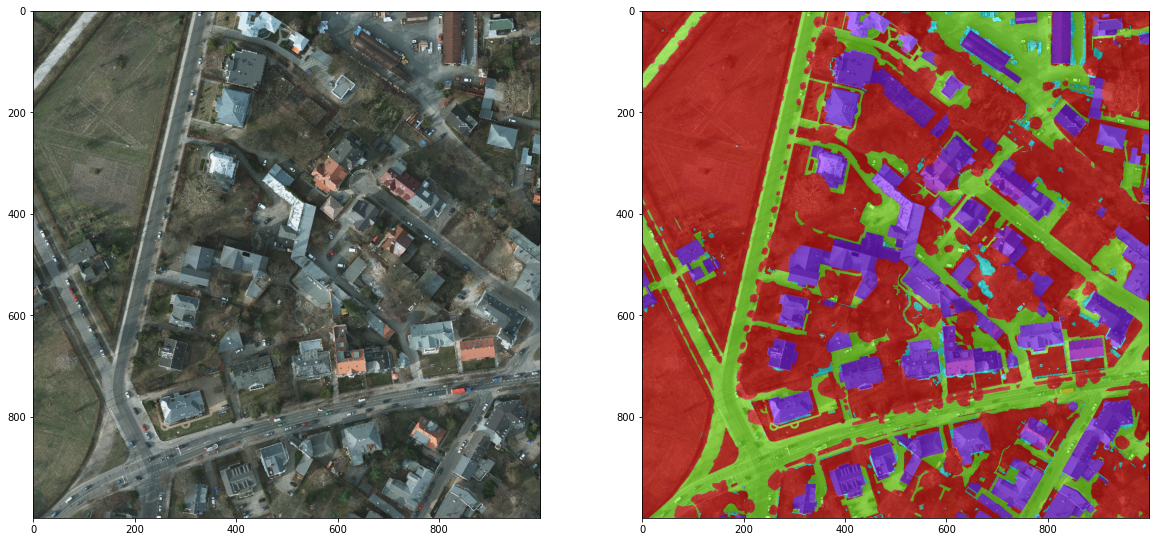

IoU and mean IoU:  [1. 1. 1. 1.] 1.0
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [27]:
# Visualize
image = cv.imread(train_imgs[0])[..., ::-1] / 255
target = cv.imread(train_imgs[0].replace("imgs", "gts"), 0)
visualize(image, target)
_, iou = get_metrics(target, target)
print("IoU and mean IoU: ", iou, np.mean(iou))
print(target)

# Architecture du résau de neurones

In [140]:


class Net(nn.Module):
  #TODO
  def __init__(self, in_channels=3, out_channels=N_CLASSES, depth=4):
    super(Net, self).__init__()
    self.downPath = nn.ModuleList()
    self.depth = depth
    n_channels=64
    for i in range(depth):
      self.downPath.append(nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=3, padding='same'),
          nn.ReLU(),
          nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding='same'),
          nn.ReLU()
          )
      )
      in_channels = n_channels
      n_channels = 2*n_channels
    
    n_channels //=2
    self.upPath = nn.ModuleList()
    for i in range(depth-1):
      n_channels //= 2
      self.upPath.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=n_channels, kernel_size=2, stride=2))
      self.upPath.append(nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=3, padding='same'),
          nn.ReLU(),
          nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding='same'),
          nn.ReLU()
      ))
      in_channels = n_channels

    self.outputLayer = nn.Conv2d(in_channels=n_channels, out_channels=out_channels, kernel_size=1, padding='same')

  def forward(self, x):
    block = []
    for idx, down in enumerate(self.downPath):
      x = down(x)
      if idx != len(self.downPath) -1:
        block.append(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)

    for idx, up in enumerate(self.upPath):
      if idx % 2 == 1:
        xs = block.pop()
        x = torch.cat([xs, x], 1)
      x = up(x)

    return self.outputLayer(x)
    
    #return  torch.rand((BATCH_SIZE, N_CLASSES, WINDOW_SIZE, WINDOW_SIZE))

net = Net()

# Définition de la fonction de test

In [137]:
def sliding_window(image, overlap=0, window_size=WINDOW_SIZE):
    """ Slide a window_shape window across the image with an overlap between 0 and 1 """
    assert overlap >= 0 and overlap < 1
    shape_img = image.shape[1]
    step = int((1-overlap) * window_size)
    for x in range(0, shape_img, step):
        if x + window_size > shape_img:
            x = shape_img - window_size
        for y in range(0, shape_img, step):
            if y + window_size > shape_img:
                y = shape_img - window_size
            yield x, y, window_size

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def from_coord_to_patch(img, coords):
    """Returns patches of the input image. coords is an output of grouper(n, sliding window(...))"""
    image_patches = [img[:, x : x + w, y : y + w] for x, y, w in coords]
    image_patches = torch.stack(image_patches).float()
    return image_patches

def test(net, test_imgs=test_imgs):
  with torch.no_grad():
    preds = []
    targets = []
    for test_img_file in tqdm(test_imgs, total=len(test_imgs)):
        img = torch.from_numpy(cv.imread(test_img_file)[..., ::-1].transpose((2, 0, 1)) / 255).to(DEVICE)
        target = cv.imread(test_img_file.replace("imgs", "gts"), 0)
        targets.append(target)
        pred = np.zeros(img.shape[1:] + (N_CLASSES,))
        for coords in grouper(BATCH_SIZE, sliding_window(img, overlap=OVERLAP, window_size=WINDOW_SIZE)):
            data_patches = from_coord_to_patch(img, coords)
            outs = net(data_patches).data.cpu().numpy()  # Avec un vrai réseau, c'est mieux !

            for out, (x, y, w) in zip(outs, coords):
                out = out.transpose((1, 2, 0))
                pred[x : x + w, y : y + w] += out
        pred = np.argmax(pred, axis=-1)
        #TODO Renvoyer métriques
        preds.append(pred)
    return get_metrics(np.array(targets), np.array(preds))
        #TODO Possiblement faire une fonction similaire pour renvoyer la prédiction pour la visualiser


# Boucle d'entrainement

In [142]:
net = Net().to(DEVICE)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [143]:

train_dataset = Potsdam_train_dataset(train_imgs)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE)
for data in tqdm(train_dataloader, total=LENGTH_EPOCH // BATCH_SIZE):
  img, target = data
  img = img.to(DEVICE).float()
  target = target.to(DEVICE).long()

  optimizer.zero_grad()
  output = net(img)
  loss = get_metrics(target, output)
  loss.backward()
  optimizer.step()
  #TODO training loop

  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: ignored